In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

In [2]:
dataset=pd.read_csv("FINAL_DATASET.csv")
dataset.shape

(1408, 16)

In [3]:
dataset.head()

,Unnamed: 0,website_url,website_name,cleaned_website_text,total_matched,matched_category_keywords,Category1,percent1,Category2,percent2,Category3,percent3,Category4,percent4,Category5,percent5
0,0,https://www.booking.com/index.html?aid=1743217,booking,official site good hotel accommodation big sav...,281,"['hotel', 'saving', 'hotel', 'destination', 'h...",Travel,62.277580,News,16.725979,Business/Corporate,14.590747,Social Networking and Messaging,11.032028,E-Commerce,9.252669
1,1,https://travelsites.com/expedia/,travelsites,expedia hotel book sites like use vacation wor...,306,"['hotel', 'book', 'vacation', 'city', 'offer',...",Travel,42.483660,E-Commerce,16.013072,Computers and Technology,15.359477,Business/Corporate,15.032680,Social Networking and Messaging,10.457516
2,2,https://travelsites.com/tripadvisor/,travelsites,tripadvisor hotel book sites like previously d...,114,"['hotel', 'book', 'deal', 'review', 'offer', '...",Travel,50.000000,Social Networking and Messaging,15.789474,Photography,13.157895,Computers and Technology,12.280702,E-Commerce,9.649123
3,3,https://www.momondo.in/?ispredir=true,momondo,cheap flights search compare flights momondo f...,411,"['cheap', 'search', 'cheap', 'flight', 'fare',...",Travel,67.396594,News,19.708029,Business/Corporate,13.381995,E-Commerce,12.408759,Computers and Technology,7.055961
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,ebookers,bot create free account create free account si...,210,"['booking', 'travel', 'travel', 'flight', 'hot...",Travel,30.000000,Social Networking and Messaging,19.523810,News,18.095238,E-Commerce,11.904762,Business/Corporate,8.095238


The dataset contains features that are not necessary to solve our multi-classification problem. For this text classification problem, we are going to build another dataframe that contains ‘website_url’,'cleaned_website_text' and 'Category'

In [4]:
df = dataset[['website_url','cleaned_website_text','Category1']].copy()
df.columns = ['website_url','cleaned_website_text','Category'] 
df.head()

,website_url,cleaned_website_text,Category
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [5]:
pd.DataFrame(df.Category.unique()).values

array([['Travel'],
       ['Social Networking and Messaging'],
       ['News'],
       ['Streaming Services'],
       ['Sports'],
       ['Photography'],
       ['Law and Government'],
       ['Health and Fitness'],
       ['Games'],
       ['E-Commerce'],
       ['Forums'],
       ['Food'],
       ['Education'],
       ['Computers and Technology'],
       ['Business/Corporate'],
       ['Adult']], dtype=object)

Now we need to represent each category as a number, so as our predictive model can better understand the different categories.

In [6]:
# Create a new column 'category_id' with encoded categories 
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

# New dataframe
df.head()

,website_url,cleaned_website_text,Category,category_id
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,0
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,0
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,0
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,0
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,0


In [7]:
category_id_df

,Category,category_id
0,Travel,0
36,Social Networking and Messaging,1
43,News,2
107,Streaming Services,3
213,Sports,4
398,Photography,5
586,Law and Government,6
670,Health and Fitness,7
768,Games,8
810,E-Commerce,9


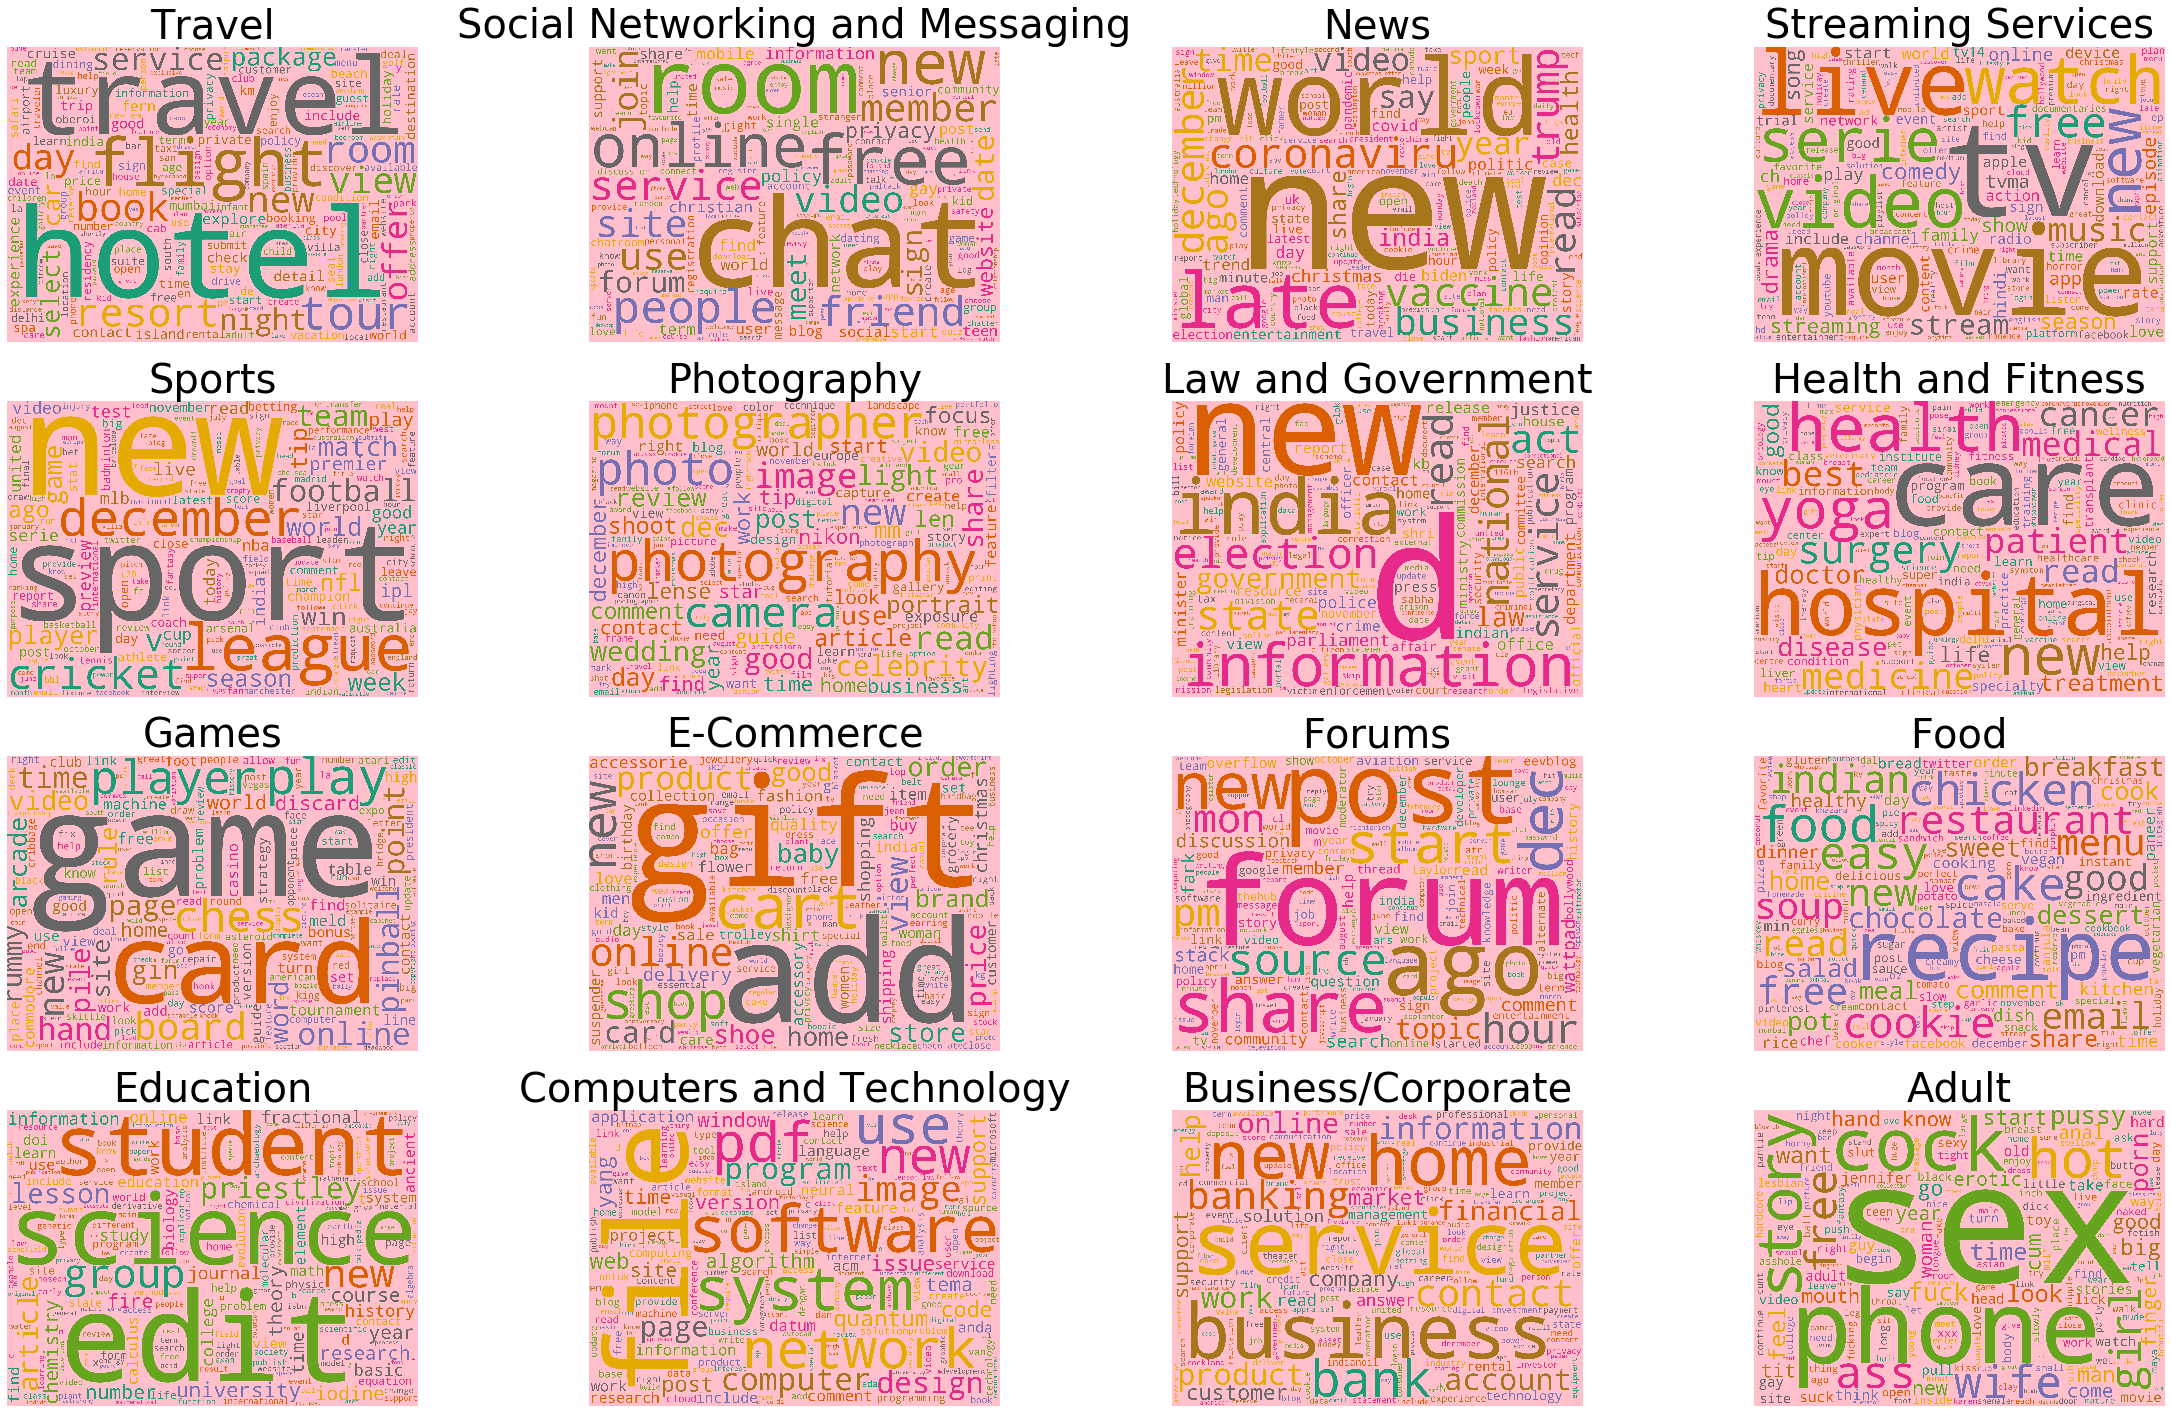

In [8]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))
subset = df[df['Category']=='Travel']
text = subset.cleaned_website_text.values
cloud1=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,1)
plt.axis('off')
plt.title("Travel",fontsize=40)
plt.imshow(cloud1)
subset = df[df['Category']=='Social Networking and Messaging']
text = subset.cleaned_website_text.values
cloud2=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,2)
plt.axis('off')
plt.title("Social Networking and Messaging",fontsize=40)
plt.imshow(cloud2)
subset = df[df['Category']=='News']
text = subset.cleaned_website_text.values
cloud3=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,3)
plt.axis('off')
plt.title("News",fontsize=40)
plt.imshow(cloud3)

subset = df[df['Category']=='Streaming Services']
text = subset.cleaned_website_text.values
cloud4=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,4)
plt.axis('off')
plt.title("Streaming Services",fontsize=40)
plt.imshow(cloud4)

subset = df[df['Category']=='Sports']
text = subset.cleaned_website_text.values
cloud5=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,5)
plt.axis('off')
plt.title('Sports',fontsize=40)
plt.imshow(cloud5)

subset = df[df['Category']=='Photography']
text = subset.cleaned_website_text.values
cloud6=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,6)
plt.axis('off')
plt.title("Photography",fontsize=40)
plt.imshow(cloud6)

subset = df[df['Category']=='Law and Government']
text = subset.cleaned_website_text.values
cloud7=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,7)
plt.axis('off')
plt.title("Law and Government",fontsize=40)
plt.imshow(cloud7)

subset = df[df['Category']=='Health and Fitness']
text = subset.cleaned_website_text.values
cloud8=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,8)
plt.axis('off')
plt.title("Health and Fitness",fontsize=40)
plt.imshow(cloud8)

subset = df[df['Category']=='Games']
text = subset.cleaned_website_text.values
cloud9=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,9)
plt.axis('off')
plt.title("Games",fontsize=40)
plt.imshow(cloud9)

subset = df[df['Category']=='E-Commerce']
text = subset.cleaned_website_text.values
cloud10=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,10)
plt.axis('off')
plt.title("E-Commerce",fontsize=40)
plt.imshow(cloud10)

subset = df[df['Category']=='Forums']
text = subset.cleaned_website_text.values
cloud11=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,11)
plt.axis('off')
plt.title("Forums",fontsize=40)
plt.imshow(cloud11)

subset = df[df['Category']=='Food']
text = subset.cleaned_website_text.values
cloud12=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,12)
plt.axis('off')
plt.title("Food",fontsize=40)
plt.imshow(cloud12)

subset = df[df['Category']=='Education']
text = subset.cleaned_website_text.values
cloud13=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,13)
plt.axis('off')
plt.title("Education",fontsize=40)
plt.imshow(cloud13)

subset =df[df['Category']=='Computers and Technology']
text = subset.cleaned_website_text.values
cloud14=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,14)
plt.axis('off')
plt.title("Computers and Technology",fontsize=40)
plt.imshow(cloud14)

subset = df[df['Category']=='Business/Corporate']
text = subset.cleaned_website_text.values
cloud15=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,15)
plt.axis('off')
plt.title("Business/Corporate",fontsize=40)
plt.imshow(cloud15)

subset = df[df['Category']=='Adult']
text = subset.cleaned_website_text.values
cloud16=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,16)
plt.axis('off')
plt.title("Adult",fontsize=40)
plt.imshow(cloud16)
plt.show()

In [9]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each cleaned_text into a vector
features = tfidf.fit_transform(df.cleaned_website_text).toarray()

labels = df.category_id

print("Each of the %d text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 1408 text is represented by 18865 features (TF-IDF score of unigrams and bigrams)


In [10]:
# Finding the three most correlated terms with each of the categories
N = 3
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Category))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Adult:
  * Most Correlated Unigrams are: porn, xxx, erotic
  * Most Correlated Bigrams are: sex toys, sex toy, erotic story

==> Business/Corporate:
  * Most Correlated Unigrams are: accounting, investment, banking
  * Most Correlated Bigrams are: home products, real estate, online banking

==> Computers and Technology:
  * Most Correlated Unigrams are: file, windows, software
  * Most Correlated Bigrams are: programming language, web hosting, source code

==> E-Commerce:
  * Most Correlated Unigrams are: accessories, accessory, shipping
  * Most Correlated Bigrams are: grocery shopping, add cart, free shipping

==> Education:
  * Most Correlated Unigrams are: biology, university, chemistry
  * Most Correlated Bigrams are: earth science, periodic table, open access

==> Food:
  * Most Correlated Unigrams are: cake, recipes, recipe
  * Most Correlated Bigrams are: order online, instant pot, gluten free

==> Forums:
  * Most Correlated Unigrams are: redirect, answers, forums
  * Mos

Spliting the data into train and test sets
The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [11]:
X = df['cleaned_website_text'] # Collection of text
y = df['Category'] # Target or the labels we want to predict

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [12]:
y_train.value_counts()

Streaming Services                 86
Education                          81
E-Commerce                         81
Health and Fitness                 79
Games                              78
Travel                             76
Business/Corporate                 75
Sports                             75
Computers and Technology           74
Law and Government                 68
Social Networking and Messaging    66
Photography                        64
News                               64
Food                               63
Adult                              14
Forums                             12
Name: Category, dtype: int64

In [13]:
y_test.value_counts()

Business/Corporate                 34
Education                          33
News                               32
Travel                             31
Photography                        29
Sports                             29
Food                               29
E-Commerce                         21
Games                              20
Computers and Technology           19
Streaming Services                 19
Social Networking and Messaging    17
Health and Fitness                 17
Law and Government                 16
Forums                              4
Adult                               2
Name: Category, dtype: int64

In [14]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    GaussianNB()
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.719858
1,RandomForestClassifier,1,0.751773
2,RandomForestClassifier,2,0.716312
3,RandomForestClassifier,3,0.736655
4,RandomForestClassifier,4,0.679715
5,LinearSVC,0,0.858156
6,LinearSVC,1,0.932624
7,LinearSVC,2,0.939716
8,LinearSVC,3,0.903915
9,LinearSVC,4,0.879004


In [15]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
GaussianNB,0.728651,0.055462
LinearSVC,0.902683,0.034687
MultinomialNB,0.852979,0.034688
RandomForestClassifier,0.720863,0.027017


In [16]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
calibrated_svc = CalibratedClassifierCV(base_estimator=model,
                                        cv="prefit")

calibrated_svc.fit(X_train,y_train)
predicted = calibrated_svc.predict(X_test)
print(metrics.accuracy_score(y_test, predicted))

0.9403409090909091


In [17]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test,predicted,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],target_names= df['Category'].unique()))

				CLASSIFICATIION METRICS

                                 precision    recall  f1-score   support

                         Travel       1.00      0.97      0.98        30
Social Networking and Messaging       0.83      0.71      0.77        14
                           News       0.92      0.88      0.90        25
             Streaming Services       1.00      0.92      0.96        26
                         Sports       0.93      0.96      0.95        28
                    Photography       0.96      0.92      0.94        25
             Law and Government       0.94      1.00      0.97        16
             Health and Fitness       0.93      0.93      0.93        29
                          Games       0.92      0.96      0.94        25
                     E-Commerce       0.97      0.97      0.97        30
                         Forums       0.00      0.00      0.00         2
                           Food       0.92      1.00      0.96        24
                     

C:\Users\hetul\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hetul\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


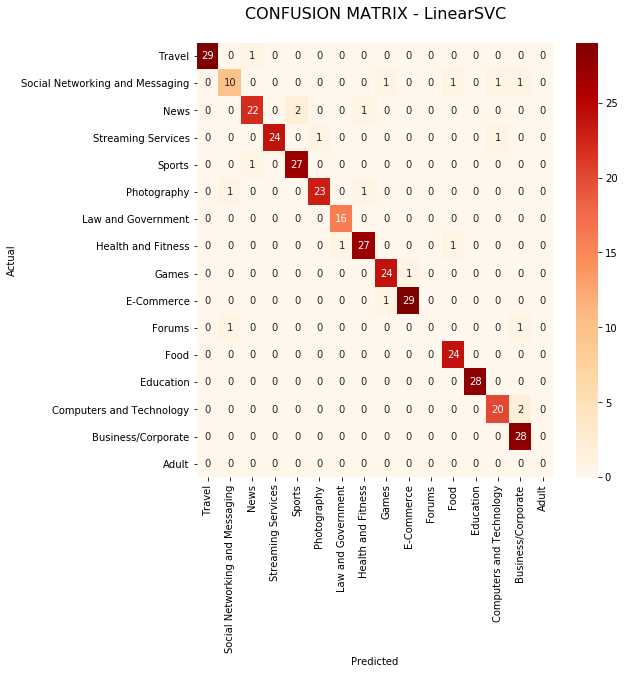

In [18]:
conf_mat = confusion_matrix(y_test, predicted,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="OrRd", fmt='d',
            xticklabels=category_id_df.Category.values, 
            yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [19]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >0:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],id_to_category[predicted],
                                                                   conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Category', 
                                                                'cleaned_website_text']])

'Photography' predicted as 'Social Networking and Messaging' : 1 examples.


,Category,cleaned_website_text
452,Photography,blipfoto photo journal simple record life phot...


'Forums' predicted as 'Social Networking and Messaging' : 1 examples.


,Category,cleaned_website_text
872,Forums,aelyria forward forums welcome aelyria page au...


'Travel' predicted as 'News' : 1 examples.


,Category,cleaned_website_text
571,Travel,timespek observe infinity timespek multi platf...


'Sports' predicted as 'News' : 1 examples.


,Category,cleaned_website_text
292,Sports,liverpool echo latest liverpool merseyside new...


'News' predicted as 'Sports' : 2 examples.


,Category,cleaned_website_text
283,News,toss cricket blog english cricket spin irrever...
512,News,page find sorry find page request follow follo...


'Streaming Services' predicted as 'Photography' : 1 examples.


,Category,cleaned_website_text


'Health and Fitness' predicted as 'Law and Government' : 1 examples.


,Category,cleaned_website_text
729,Health and Fitness,safety training compliance online federal osha...


'News' predicted as 'Health and Fitness' : 1 examples.


,Category,cleaned_website_text
757,News,vet times website veterinary profession bring ...


'Photography' predicted as 'Health and Fitness' : 1 examples.


,Category,cleaned_website_text
460,Photography,filemagazine filemagazine whiten anus use lemo...


'Social Networking and Messaging' predicted as 'Games' : 1 examples.


,Category,cleaned_website_text
383,Social Networking and Messaging,chat rooms chat games avatar chat chat chat ro...


'E-Commerce' predicted as 'Games' : 1 examples.


,Category,cleaned_website_text
810,E-Commerce,port macquarie hastings bridge club welcome we...


'Games' predicted as 'E-Commerce' : 1 examples.


,Category,cleaned_website_text
833,Games,pinball mods accessory mezel mods accessory mo...


'Social Networking and Messaging' predicted as 'Food' : 1 examples.


,Category,cleaned_website_text
350,Social Networking and Messaging,pinterest discover recipe home idea style insp...


'Health and Fitness' predicted as 'Food' : 1 examples.


,Category,cleaned_website_text
702,Health and Fitness,joyous health simple healthy living inspiratio...


'Social Networking and Messaging' predicted as 'Computers and Technology' : 1 examples.


,Category,cleaned_website_text
372,Social Networking and Messaging,attention required cloudflare step complete se...


'Streaming Services' predicted as 'Computers and Technology' : 1 examples.


,Category,cleaned_website_text
177,Streaming Services,tm internet streaming media wireless multicast...


'Social Networking and Messaging' predicted as 'Business/Corporate' : 1 examples.


,Category,cleaned_website_text
348,Social Networking and Messaging,linkedin log sign member manage professional i...


'Forums' predicted as 'Business/Corporate' : 1 examples.


,Category,cleaned_website_text
880,Forums,forum thehub online forums skip navigation ski...


'Computers and Technology' predicted as 'Business/Corporate' : 2 examples.


,Category,cleaned_website_text
1212,Computers and Technology,computer repair laptop repair support brighton...
1199,Computers and Technology,network visibility monitoring solutions profit...


In [20]:
model.fit(features, labels)

N = 4
for Category, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Category))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Adult':
  * Top unigrams: bdsm, sex, erotic, bondage
  * Top bigrams: erotic story, sex toy, sex toys, live sex

==> 'Business/Corporate':
  * Top unigrams: investment, client, company, business
  * Top bigrams: real estate, audio visual, year experience, site work

==> 'Computers and Technology':
  * Top unigrams: software, file, web, windows
  * Top bigrams: source code, web hosting, come soon, easy use

==> 'E-Commerce':
  * Top unigrams: shipping, grocery, item, gift
  * Top bigrams: free shipping, gift card, grocery shopping, add cart

==> 'Education':
  * Top unigrams: university, science, student, chemistry
  * Top bigrams: open access, multiple choice, annual meeting, state university

==> 'Food':
  * Top unigrams: recipe, cake, restaurant, tasty
  * Top bigrams: order online, gluten free, home menu, breakfast lunch

==> 'Forums':
  * Top unigrams: forums, forum, answers, google
  * Top bigrams: share knowledge, mon dec, hour ago, post hour

==> 'Games':
  * Top unigrams:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, df['category_id'], 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

m = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)
m1=CalibratedClassifierCV(base_estimator=m,
                                        cv="prefit").fit(tfidf_vectorizer_vectors, y_train)


In [22]:
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
from collections import Counter
import pandas as pd
import os
class ScrapTool:
    def visit_url(self, website_url):
        '''
        Visit URL. Download the Content. Initialize the beautifulsoup object. Call parsing methods. Return Series object.
        '''
        #headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36'}
        content = requests.get(website_url,timeout=60).content
        
        #lxml is apparently faster than other settings.
        soup = BeautifulSoup(content, "lxml")
        result = {
            "website_url": website_url,
            "website_name": self.get_website_name(website_url),
            "website_text": self.get_html_title_tag(soup)+self.get_html_meta_tags(soup)+self.get_html_heading_tags(soup)+
                                                               self.get_text_content(soup)
        }
        
        #Convert to Series object and return
        return pd.Series(result)
    
    def get_website_name(self,website_url):
        '''
        Example: returns "google" from "www.google.com"
        '''
        return "".join(urlparse(website_url).netloc.split(".")[-2])
    
    def get_html_title_tag(self,soup):
        '''Return the text content of <title> tag from a webpage'''
        return '. '.join(soup.title.contents)
    
    def get_html_meta_tags(self,soup):
        '''Returns the text content of <meta> tags related to keywords and description from a webpage'''
        tags = soup.find_all(lambda tag: (tag.name=="meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
        content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords','description']]
        return ' '.join(content)
    
    def get_html_heading_tags(self,soup):
        '''returns the text content of heading tags. The assumption is that headings might contain relatively important text.'''
        tags = soup.find_all(["h1","h2","h3","h4","h5","h6"])
        content = [" ".join(tag.stripped_strings) for tag in tags]
        return ' '.join(content)
    
    def get_text_content(self,soup):
        '''returns the text content of the whole page with some exception to tags. See tags_to_ignore.'''
        tags_to_ignore = ['style', 'script', 'head', 'title', 'meta', '[document]',"h1","h2","h3","h4","h5","h6","noscript"]
        tags = soup.find_all(text=True)
        result = []
        for tag in tags:
            stripped_tag = tag.strip()
            if tag.parent.name not in tags_to_ignore\
                and isinstance(tag, bs4.element.Comment)==False\
                and not stripped_tag.isnumeric()\
                and len(stripped_tag)>0:
                result.append(stripped_tag)
        return ' '.join(result)

import spacy as sp
from collections import Counter
sp.prefer_gpu()
import en_core_web_sm
#anconda prompt ko run as adminstrator and copy paste this:python -m spacy download en
nlp = en_core_web_sm.load()
import re
def clean_text(doc):
    '''
    Clean the document. Remove pronouns, stopwords, lemmatize the words and lowercase them
    '''
    doc = nlp(doc)
    tokens = []
    exclusion_list = ["nan"]
    for token in doc:
        if token.is_stop or token.is_punct or token.text.isnumeric() or (token.text.isalnum()==False) or token.text in exclusion_list :
            continue
        token = str(token.lemma_.lower().strip())
        tokens.append(token)
    return " ".join(tokens) 


In [39]:
website=input('enter url: ')
scrapTool = ScrapTool()
try:
    web=dict(scrapTool.visit_url(website))
    text=(clean_text(web['website_text']))
    t=fitted_vectorizer.transform([text])
    print(id_to_category[m1.predict(t)[0]])
    data=pd.DataFrame(m1.predict_proba(t)*100,columns=df['Category'].unique())
    data=data.T
    data.columns=['Probability']
    data.index.name='Category'
    a=data.sort_values(['Probability'],ascending=False)
    a['Probability']=a['Probability'].apply(lambda x:round(x,2))
except:
    print("Connection Timedout!")

enter url: http://www.bananaleafindia.com/
Food


In [40]:
a

,Probability
Category,
Food,97.88
Travel,0.32
Photography,0.23
Education,0.16
Health and Fitness,0.15
E-Commerce,0.14
Forums,0.14
Law and Government,0.14
Social Networking and Messaging,0.13


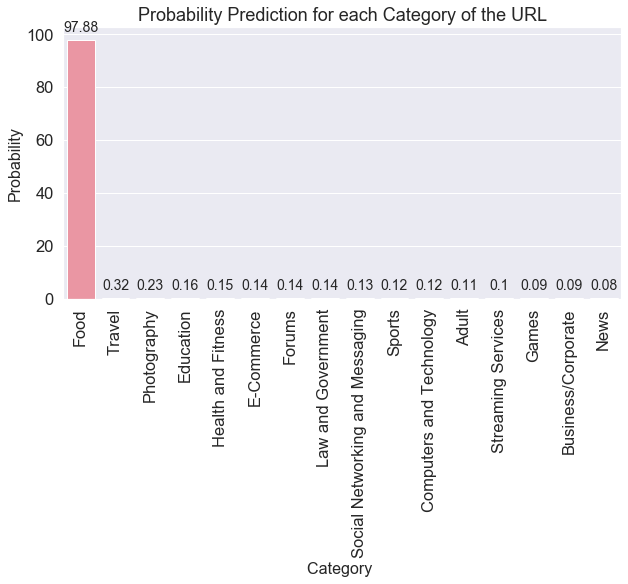

In [41]:
sns.set(font_scale = 1.5)
plt.figure(figsize=(10,5))
i=list(a.index)
ax= sns.barplot(i,a['Probability'])

plt.title("Probability Prediction for each Category of the URL", fontsize=18)
plt.ylabel('Probability', fontsize=16)
plt.xlabel('Category ', fontsize=16)

#adding the text labels
rects = ax.patches
labels = a['Probability']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 2, label, ha='center', va='bottom', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.show()